Input:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

from model.modelcore import epid_model
from model.modelhelper import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


## Optimization Settings

In [3]:
start_time='2020-02-26'
end_time='2020-09-30'
observations=['Confirmed_cases', 'Admissions_hospital'] # ['Number_of_deaths', 'Confirmed_cases', 'Admissions_hospital']

dtype = torch.float32
device = torch.device("cuda:0") #cuda:0

## Initialize Observations

In [4]:
df_obs_initial = pd.read_csv('data/observations_03022022.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])
df_obs = initialize_observations(df_obs_initial, start=start_time, end=end_time, observations=observations)
observed = torch.tensor(df_obs['Confirmed_cases'], requires_grad=False, device=device, dtype=dtype)
df_obs.head(3)

,Date,Confirmed_cases,Admissions_hospital
0,2020-02-26,1,0
1,2020-02-27,1,0
2,2020-02-28,1,0


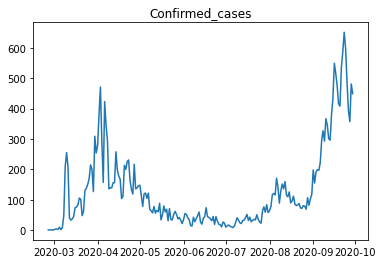

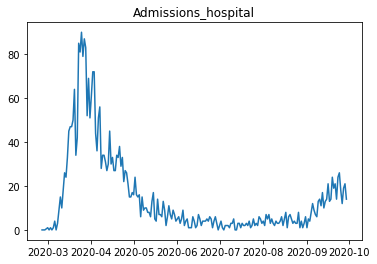

In [5]:
for observation in observations:
  plt.plot(df_obs['Date'], df_obs[observation])
  plt.title(observation)
  plt.show()

## Initialize Model Parameter

### Initialize Helper Parameter

In [6]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_observations = df_obs.shape[0]
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)

### Initialize to be optimized Model Parameter

In [7]:
parameter = ['alpha', 'sigma']
dict_param = initialize_parameter(parameter, device=device, dtype=dtype)

In [8]:
epsilon_t = initialize_epsilon(num_observations, dict_param['real_values']['sigma'], dtype=dtype, device=device)

# Optimization

## Training

Step: 0, Time: 1.072263240814209, Loss: 34901.38671875, Mean Expected Daily Hospit: 0.420379102230072


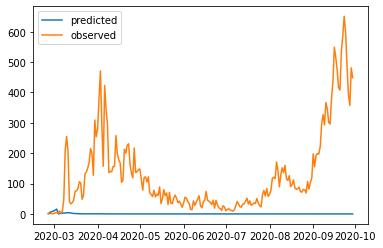

Step: 5, Time: 0.820275068283081, Loss: 34891.5234375, Mean Expected Daily Hospit: 0.4594563841819763
Step: 10, Time: 1.0884954929351807, Loss: 34878.671875, Mean Expected Daily Hospit: 0.5071228742599487
Step: 15, Time: 0.7875187397003174, Loss: 34861.42578125, Mean Expected Daily Hospit: 0.5672034621238708
Step: 20, Time: 0.3887038230895996, Loss: 34837.57421875, Mean Expected Daily Hospit: 0.645776629447937
Step: 25, Time: 0.38271164894104004, Loss: 34803.50390625, Mean Expected Daily Hospit: 0.7529224753379822
Step: 30, Time: 0.37502193450927734, Loss: 34753.19140625, Mean Expected Daily Hospit: 0.9064109325408936
Step: 35, Time: 0.3830900192260742, Loss: 34675.765625, Mean Expected Daily Hospit: 1.1406431198120117
Step: 40, Time: 0.39604949951171875, Loss: 34546.6875, Mean Expected Daily Hospit: 1.533780813217163
Step: 45, Time: 0.38243603706359863, Loss: 34272.48828125, Mean Expected Daily Hospit: 2.3224031925201416
Step: 50, Time: 0.37540435791015625, Loss: 33251.6171875, Mean E

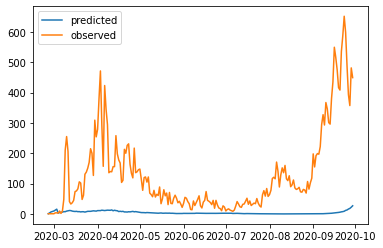

Step: 55, Time: 0.3894984722137451, Loss: 27417.990234375, Mean Expected Daily Hospit: 15.127195358276367
Step: 60, Time: 0.38251709938049316, Loss: 23667.482421875, Mean Expected Daily Hospit: 53.902740478515625
Step: 65, Time: 0.3841898441314697, Loss: 22083.9609375, Mean Expected Daily Hospit: 28.875293731689453
Step: 70, Time: 0.4026329517364502, Loss: 20505.611328125, Mean Expected Daily Hospit: 36.23537063598633
Step: 75, Time: 0.38715243339538574, Loss: 20341.888671875, Mean Expected Daily Hospit: 51.67180252075195
Step: 80, Time: 0.4159090518951416, Loss: 19466.314453125, Mean Expected Daily Hospit: 40.475120544433594
Step: 85, Time: 0.39591336250305176, Loss: 18547.701171875, Mean Expected Daily Hospit: 48.01193618774414
Step: 90, Time: 0.40062475204467773, Loss: 17966.212890625, Mean Expected Daily Hospit: 54.631771087646484
Step: 95, Time: 0.41597700119018555, Loss: 17270.888671875, Mean Expected Daily Hospit: 51.840572357177734
Step: 100, Time: 0.4015645980834961, Loss: 164

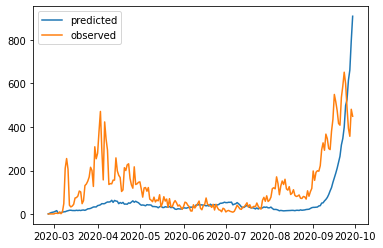

Step: 105, Time: 0.41222167015075684, Loss: 15528.73046875, Mean Expected Daily Hospit: 63.540748596191406
Step: 110, Time: 0.4064631462097168, Loss: 14625.263671875, Mean Expected Daily Hospit: 68.64797973632812
Step: 115, Time: 0.39264535903930664, Loss: 13690.98828125, Mean Expected Daily Hospit: 76.62471771240234
Step: 120, Time: 0.3956735134124756, Loss: 12750.5166015625, Mean Expected Daily Hospit: 80.79743194580078
Step: 125, Time: 0.4030721187591553, Loss: 11836.9443359375, Mean Expected Daily Hospit: 89.52174377441406
Step: 130, Time: 0.3970465660095215, Loss: 10973.1806640625, Mean Expected Daily Hospit: 94.26311492919922
Step: 135, Time: 0.38315439224243164, Loss: 10155.462890625, Mean Expected Daily Hospit: 100.54830932617188
Step: 140, Time: 0.38855719566345215, Loss: 9365.8115234375, Mean Expected Daily Hospit: 104.18273162841797
Step: 145, Time: 0.3822340965270996, Loss: 8591.431640625, Mean Expected Daily Hospit: 107.1504898071289
Step: 150, Time: 0.396909236907959, Los

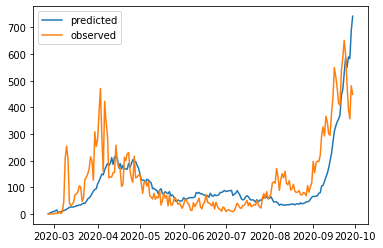

Step: 155, Time: 0.37797045707702637, Loss: 7107.19140625, Mean Expected Daily Hospit: 110.19308471679688
Step: 160, Time: 0.37556934356689453, Loss: 6416.68505859375, Mean Expected Daily Hospit: 111.41194915771484
Step: 165, Time: 0.3936283588409424, Loss: 5768.52685546875, Mean Expected Daily Hospit: 112.58928680419922
Step: 170, Time: 0.38956618309020996, Loss: 5166.75341796875, Mean Expected Daily Hospit: 114.04014587402344
Step: 175, Time: 0.39636945724487305, Loss: 4616.43798828125, Mean Expected Daily Hospit: 115.61166381835938
Step: 180, Time: 0.37129831314086914, Loss: 4122.79833984375, Mean Expected Daily Hospit: 117.18367767333984
Step: 185, Time: 0.3878169059753418, Loss: 3689.300048828125, Mean Expected Daily Hospit: 118.76908111572266
Step: 190, Time: 0.3811328411102295, Loss: 3316.125244140625, Mean Expected Daily Hospit: 120.07443237304688
Step: 195, Time: 0.37180614471435547, Loss: 2999.77490234375, Mean Expected Daily Hospit: 121.29959106445312
Step: 200, Time: 0.4107

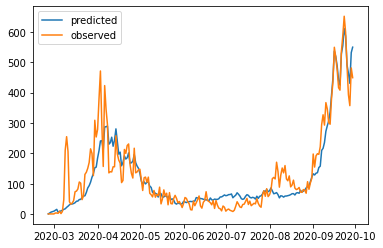

Step: 205, Time: 0.3942713737487793, Loss: 2509.604248046875, Mean Expected Daily Hospit: 123.00080108642578
Step: 210, Time: 0.38294458389282227, Loss: 2318.925537109375, Mean Expected Daily Hospit: 123.59632110595703
Step: 215, Time: 0.39953112602233887, Loss: 2154.12158203125, Mean Expected Daily Hospit: 124.11029052734375
Step: 220, Time: 0.38628149032592773, Loss: 2009.3717041015625, Mean Expected Daily Hospit: 124.54036712646484
Step: 225, Time: 0.3944206237792969, Loss: 1880.671142578125, Mean Expected Daily Hospit: 124.89239501953125
Step: 230, Time: 0.380828857421875, Loss: 1765.4931640625, Mean Expected Daily Hospit: 125.21578216552734
Step: 235, Time: 0.3855617046356201, Loss: 1662.286865234375, Mean Expected Daily Hospit: 125.47787475585938
Step: 240, Time: 0.518284797668457, Loss: 1570.0106201171875, Mean Expected Daily Hospit: 125.71701049804688
Step: 245, Time: 0.3910224437713623, Loss: 1487.8201904296875, Mean Expected Daily Hospit: 125.92694854736328
Step: 250, Time: 0

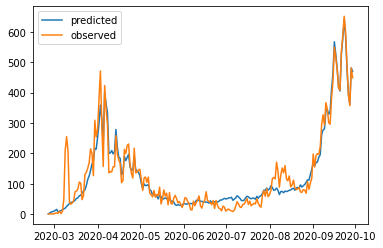

Step: 255, Time: 0.37941408157348633, Loss: 1350.4053955078125, Mean Expected Daily Hospit: 126.29681396484375
Step: 260, Time: 0.38341832160949707, Loss: 1293.4656982421875, Mean Expected Daily Hospit: 126.46746826171875
Step: 265, Time: 0.3773379325866699, Loss: 1243.2147216796875, Mean Expected Daily Hospit: 126.63581085205078
Step: 270, Time: 0.3676750659942627, Loss: 1198.8221435546875, Mean Expected Daily Hospit: 126.80083465576172
Step: 275, Time: 0.37836384773254395, Loss: 1159.517822265625, Mean Expected Daily Hospit: 126.95862579345703
Step: 280, Time: 0.3777754306793213, Loss: 1124.6068115234375, Mean Expected Daily Hospit: 127.11048126220703
Step: 285, Time: 0.37633824348449707, Loss: 1093.4754638671875, Mean Expected Daily Hospit: 127.25238037109375
Step: 290, Time: 0.3944995403289795, Loss: 1065.591552734375, Mean Expected Daily Hospit: 127.38284301757812
Step: 295, Time: 0.37798285484313965, Loss: 1040.4979248046875, Mean Expected Daily Hospit: 127.50220489501953
Step: 3

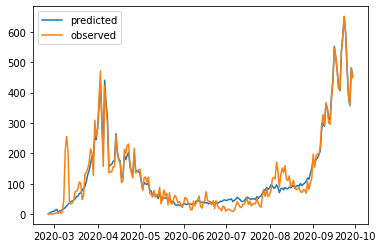

Step: 305, Time: 0.39492130279541016, Loss: 997.1876220703125, Mean Expected Daily Hospit: 127.70488739013672
Step: 310, Time: 0.38889193534851074, Loss: 978.3631591796875, Mean Expected Daily Hospit: 127.79010009765625
Step: 315, Time: 0.39330482482910156, Loss: 961.0967407226562, Mean Expected Daily Hospit: 127.86540985107422
Step: 320, Time: 0.38115882873535156, Loss: 945.1875, Mean Expected Daily Hospit: 127.93199920654297
Step: 325, Time: 0.37750816345214844, Loss: 930.4632568359375, Mean Expected Daily Hospit: 127.99115753173828
Step: 330, Time: 0.38424205780029297, Loss: 916.776611328125, Mean Expected Daily Hospit: 128.04359436035156
Step: 335, Time: 0.3854355812072754, Loss: 904.0003051757812, Mean Expected Daily Hospit: 128.0904998779297
Step: 340, Time: 0.3818683624267578, Loss: 892.0248413085938, Mean Expected Daily Hospit: 128.13287353515625
Step: 345, Time: 0.38953113555908203, Loss: 880.7556762695312, Mean Expected Daily Hospit: 128.17127990722656
Step: 350, Time: 0.3758

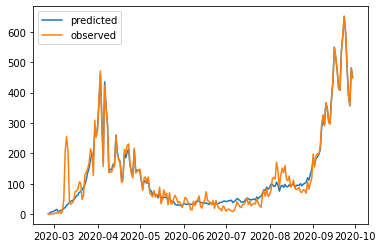

Step: 355, Time: 0.3785066604614258, Loss: 860.0223388671875, Mean Expected Daily Hospit: 128.23886108398438
Step: 360, Time: 0.40294432640075684, Loss: 850.4281616210938, Mean Expected Daily Hospit: 128.26890563964844
Step: 365, Time: 0.39543819427490234, Loss: 841.2774047851562, Mean Expected Daily Hospit: 128.2969512939453
Step: 370, Time: 0.39795780181884766, Loss: 832.5260620117188, Mean Expected Daily Hospit: 128.32313537597656
Step: 375, Time: 0.43234872817993164, Loss: 824.135986328125, Mean Expected Daily Hospit: 128.34764099121094
Step: 380, Time: 0.41579222679138184, Loss: 816.0750122070312, Mean Expected Daily Hospit: 128.37049865722656
Step: 385, Time: 0.3994107246398926, Loss: 808.3155517578125, Mean Expected Daily Hospit: 128.39219665527344
Step: 390, Time: 0.3679676055908203, Loss: 800.8336791992188, Mean Expected Daily Hospit: 128.41256713867188
Step: 395, Time: 0.3947148323059082, Loss: 793.6091918945312, Mean Expected Daily Hospit: 128.4315185546875
Step: 400, Time: 

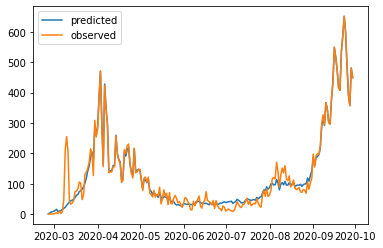

KeyboardInterrupt: ignored

In [9]:
epochs = 1000

params_to_be_optimized = [epsilon_t]
for param in parameter:
  params_to_be_optimized.append(dict_param['prime_values'][param])

optimizer = optim.Adam(params_to_be_optimized, lr=0.01, weight_decay=1e-8)

for i in range(epochs):
  start_time = time.time()
  optimizer.zero_grad()

  # forward pass
  transform_prime_variables(dict_param)
  expected = epid_model(population, R=torch.abs(epsilon_t), initial_newly_infected=np.arange(1, 18, 3), alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)['newly_infected']

  # calc loss
  loss = calc_mse(expected, observed)

  # backward pass
  loss.backward()
  optimizer.step()

  if i % 5==0:
      print(f'Step: {i}, Time: {time.time() - start_time}, Loss: {loss}, Mean Expected Daily Hospit: {expected.cpu().detach().numpy().mean()}')
  
  if i % 50==0:
    plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
    plt.plot(df_obs['Date'], observed.cpu().detach().numpy(), label='observed')
    plt.legend()
    plt.show()


# Evaluation

In [ ]:
plt.plot(df_obs['Date'], observed.cpu().detach().numpy())
plt.title('observed')
plt.show()

In [ ]:
plt.plot(df_obs['Date'], expected.cpu().detach().numpy())
plt.title('expected')
plt.show()